# Think Green Investing 

## Imports

In [66]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt
import panel as pn

pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
from pathlib import Path
import plotly.graph_objects as go
import plotly.offline as pyo

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from numpy.random import seed
from tensorflow import random

%matplotlib inline

In [67]:
# Initializing alpaca trade api
load_dotenv()
alpaca_api_key=os.getenv('ALPACA_API_KEY')
alpaca_secret_key=os.getenv('ALPACA_SECRET_KEY')
alpaca=tradeapi.REST(alpaca_api_key,alpaca_secret_key, api_version='v2')

# Data Collection

In [68]:
# Function that pulls tickers daily closing prices in the given time period using alpaca trade api, 
# Initialization of the api is required before using.
# It returns a dataframe with the tickers, and closing prices as two level column structured dataframe with index defined as date  

def get_tickers_data(tickers, start_date, end_date, timeframe):
    start_date = pd.Timestamp(start_date, tz = "America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz = "America/New_York").isoformat()
    tickers_data_df = alpaca.get_bars(tickers, timeframe,start_date , end_date, adjustment = 'raw').df
    tickers_data_df.index = tickers_data_df.index.date
    tickers_data_df = tickers_data_df[['symbol', 'close']]
    tickers_data_list=[]
    for ticker in tickers:
        tickers_data_list.append(tickers_data_df[tickers_data_df['symbol']==ticker].drop('symbol', axis=1))
        
    clean_tickers_data = pd.concat(tickers_data_list,axis=1, keys=tickers)
    return clean_tickers_data

In [69]:
#defining the stocks in the solar energy portfolio form top performers in 2021 using Motley Fool and Investopedia. The companies are:
#1.First Solar (FSLR)
#2.Solar Edge Technologies (SEDG)
#3.Daqo New Energy Corp. (DQ)
#4.Canadian Solar INC (CSIQ)
#5.Algonquin Power & Utilities Corp (AQN)

# Initialize data

portfolio = ['FSLR' , 'SEDG', 'DQ', 'CSIQ', 'AQN']
indices = ['SPY']
timeframe='1Day'
tickers = portfolio + indices

### Set the Period: from Jan 2019 to June 2022

In [70]:
#Setting up period and pulling data and cleaning it  
start_date = '2019-01-01'
end_date = '2022-06-15'

tickers_data = get_tickers_data(tickers, start_date, end_date, timeframe) 



In [71]:
# Calculating portfolio daily value based on initial investment and equal weight to each stock

capital = 1e5

tickers_data['Portfolio'] = capital + tickers_data.drop(columns = 'SPY').pct_change().cumsum().mean(axis = 1) *capital
tickers_data.dropna(inplace = True)

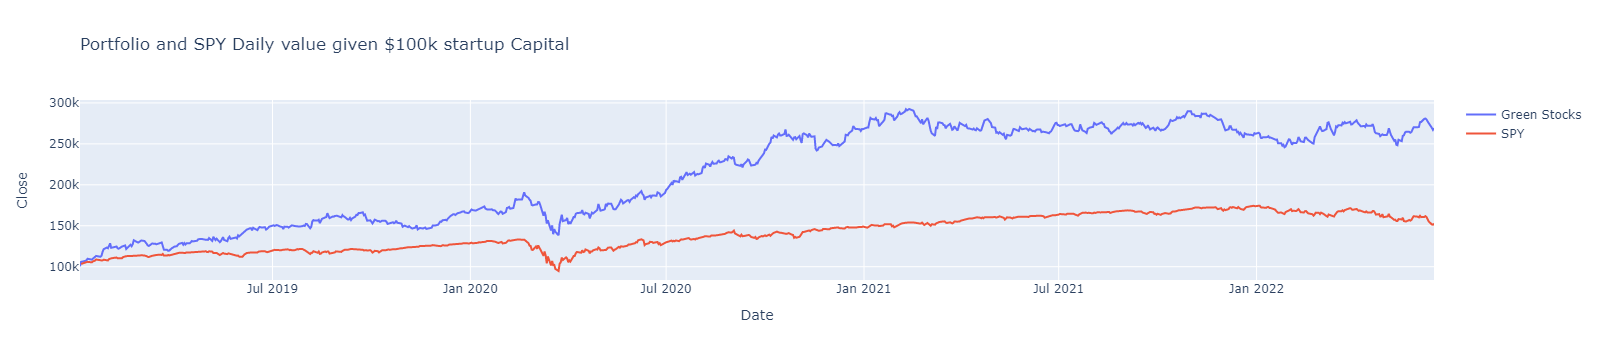

In [72]:
# Calculating SPY daily value based on the same initial investment as the green portfolio

SPY_returns =capital + tickers_data["SPY"].pct_change().cumsum().dropna() * capital
SPY_returns.dropna(inplace = True)

#plot SPY value vs Portfolio value for comparison
trace1 = go.Scatter(
    x = tickers_data["Portfolio"].index,
    y = tickers_data["Portfolio"],
    mode = 'lines',
    name = 'Green Stocks'
)
trace2 = go.Scatter(
    x = SPY_returns.index,
    y = SPY_returns['close'],
    mode = 'lines',
    name = 'SPY'
)

layout = go.Layout(
    title = "Portfolio and SPY Daily value given $100k startup Capital",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
data=[trace1, trace2]
#pyo.iplot(data, filename = 'basic-line', layout=layout)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


# Machine Learning Model to Predict Portfolio and SPY Future Trends

In [73]:
#function that takes a dataframe, the window for LSTM model, and the test-validation split ratio 
#and returns the test_train, validation_train, prediction as arrays and the model.   

def predict_price(df_close, window, split_percent):
    #prepare the data and convert them to one dimensional array
    close_data = df_close.values
    close_data = close_data.reshape((-1,1))
    #get the split index
    split = int(split_percent*len(close_data))
    #split the data
    close_train = close_data[:split]
    close_test = close_data[split:]
    
    #Use time serios to prepare the data for LSTM model given the look back value
    look_back = window
    train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
    test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)
    
    #create the model
    model = Sequential()
    model.add(
        LSTM(10,
            activation='relu',
            input_shape=(look_back,1))
        )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    num_epochs = 25
    #train the model
    model.fit_generator(train_generator, epochs=num_epochs, verbose=1)
    #test the model
    prediction = model.predict_generator(test_generator)

    #reshape data
    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))
    return close_train, close_test, prediction, model 

## Generate Models for the Green Stocks Portfolio and SPY

In [74]:
window = 10
split_per= 0.8
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)
#get model for the green protfolio
close_train, close_test, prediction, model_p = predict_price(tickers_data['Portfolio'].dropna(), window, split_per)
# Reset the random seed 
seed(1)
random.set_seed(2)
#get model for SPY
close_train_spy, close_test_spy, prediction_spy, model_spy = predict_price(SPY_returns['close'].dropna(), window, split_per)


Epoch 1/25


C:\Users\amany\Anaconda3\envs\alpacaenv\lib\site-packages\ipykernel_launcher.py:31: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



35/35 [==============================] - 1s 2ms/step - loss: 53393453056.0000
Epoch 2/25
35/35 [==============================] - 0s 3ms/step - loss: 42232897536.0000
Epoch 3/25
35/35 [==============================] - 0s 3ms/step - loss: 37537206272.0000
Epoch 4/25
35/35 [==============================] - 0s 3ms/step - loss: 33611907072.0000
Epoch 5/25
35/35 [==============================] - 0s 2ms/step - loss: 30446354432.0000
Epoch 6/25
35/35 [==============================] - 0s 2ms/step - loss: 27567958016.0000
Epoch 7/25
35/35 [==============================] - 0s 2ms/step - loss: 24542474240.0000
Epoch 8/25
35/35 [==============================] - 0s 3ms/step - loss: 21682694144.0000
Epoch 9/25
35/35 [==============================] - 0s 3ms/step - loss: 18862297088.0000
Epoch 10/25
35/35 [==============================] - 0s 2ms/step - loss: 16150977536.0000
Epoch 11/25
35/35 [==============================] - 0s 3ms/step - loss: 13413806080.0000
Epoch 12/25
35/35 [===========

C:\Users\amany\Anaconda3\envs\alpacaenv\lib\site-packages\ipykernel_launcher.py:33: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Epoch 1/25
35/35 [==============================] - 1s 3ms/step - loss: 22809481216.0000
Epoch 2/25
35/35 [==============================] - 0s 3ms/step - loss: 15124805632.0000
Epoch 3/25
35/35 [==============================] - 0s 2ms/step - loss: 12417695744.0000
Epoch 4/25
35/35 [==============================] - 0s 2ms/step - loss: 9756048384.0000
Epoch 5/25
35/35 [==============================] - 0s 2ms/step - loss: 7000253440.0000
Epoch 6/25
35/35 [==============================] - 0s 2ms/step - loss: 4338240512.0000
Epoch 7/25
35/35 [==============================] - 0s 2ms/step - loss: 17280544768.0000
Epoch 8/25
35/35 [==============================] - 0s 2ms/step - loss: 13904276480.0000
Epoch 9/25
35/35 [==============================] - 0s 2ms/step - loss: 2168918784.0000
Epoch 10/25
35/35 [==============================] - 0s 3ms/step - loss: 1051221440.0000
Epoch 11/25
35/35 [==============================] - 0s 3ms/step - loss: 369652160.0000
Epoch 12/25
35/35 [=======

In [75]:
split = int(split_per*len(tickers_data))
date_train = tickers_data.index[:split].dropna()
date_test = tickers_data.index[split:].dropna()
len(prediction)

164

## Plot Train and Test Results

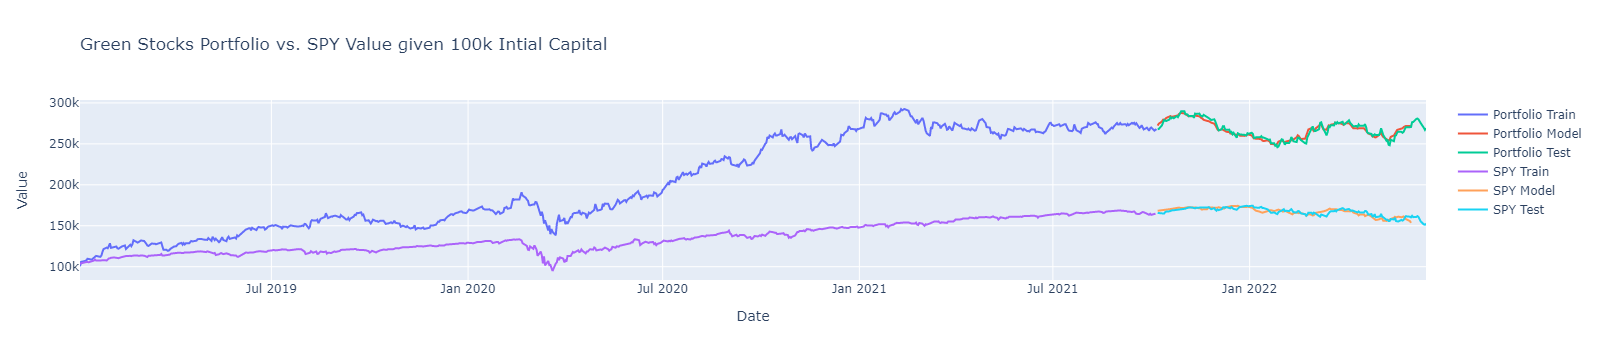

In [76]:
#pulling the dates from the data frame

#plot the train and test results
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Portfolio Train'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Portfolio Model'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Portfolio Test'
)
trace4 = go.Scatter(
    x = date_train,
    y = close_train_spy,
    mode = 'lines',
    name = 'SPY Train'
)
trace5 = go.Scatter(
    x = date_test,
    y = prediction_spy,
    mode = 'lines',
    name = 'SPY Model'
)
trace6 = go.Scatter(
    x = date_test,
    y = close_test_spy,
    mode='lines',
    name = 'SPY Test'
)
layout = go.Layout(
    title = "Green Stocks Portfolio vs. SPY Value given 100k Intial Capital",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Value"}
)
data=[trace1, trace2, trace3,trace4, trace5, trace6]
#pyo.iplot(data, filename = 'basic-line')
fig = go.Figure(data, layout=layout)
fig.show()


## Predict Future Trends

In [103]:
#function that takes closing prices as an array of values, the number of predictions expected, the LSTM model, and the look back value for the model. 
#It returns an array with the predicted values using the given model 
def predict(close_data, num_prediction, model, look_back):
    close_data = close_data.reshape((-1))
    prediction_list = close_data[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    return prediction_list
#function that takes a data frame of values, the look back value for the model and the LSTM model, the number of predictions expected. 
#It converts the data fram to an array, get the predicted values using the predict function, and generate the dates that matches the number of predictions expected.
#it returns two arrays, the forcasted dates and values 
def forecast_close(tickers_df, look_back, model,num_prediction):
    
    close_data = tickers_df.dropna().values.reshape((-1))
    forecast = predict(close_data, num_prediction, model, look_back)
    last_date = tickers_df.index.values[-1]
    forecast_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return forecast, forecast_dates

In [104]:
#forcast the portfolio and SPY trend in the following 10 days
forecast, forecast_dates = forecast_close(tickers_data['Portfolio'], 10, model_p,30)
forecast_spy, forecast_dates_spy = forecast_close(SPY_returns['close'].dropna(), 10, model_spy,30)


1/1 [==============================] - 0s 14ms/step


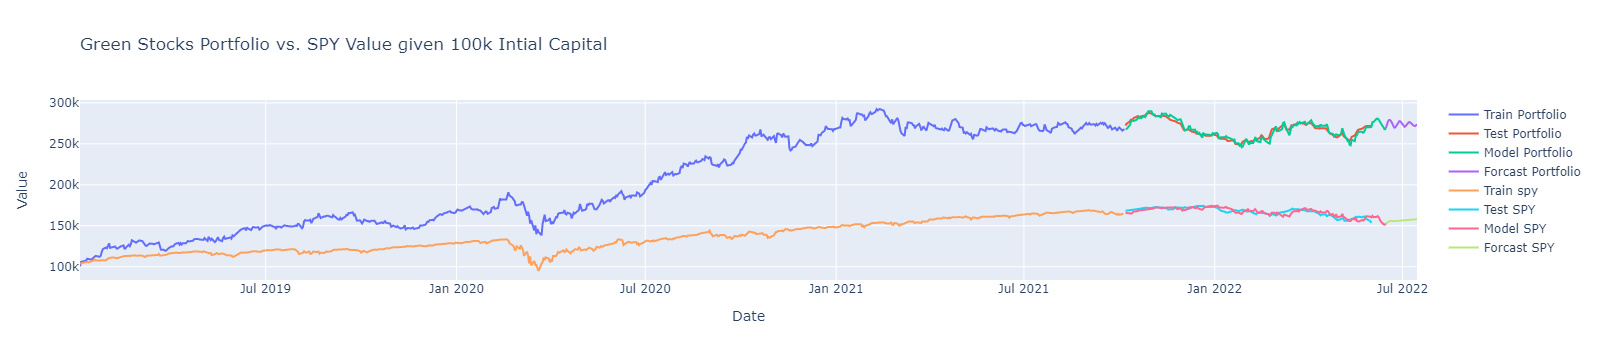

In [107]:
#plot the results
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Train Portfolio'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Test Portfolio'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Model Portfolio'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Forcast Portfolio'
)
trace5 = go.Scatter(
    x = date_train,
    y = close_train_spy,
    mode = 'lines',
    name = 'Train spy'
)
trace6 = go.Scatter(
    x = date_test,
    y = prediction_spy,
    mode = 'lines',
    name = 'Test SPY'
)
trace7 = go.Scatter(
    x = date_test,
    y = close_test_spy,
    mode='lines',
    name = 'Model SPY'
)
trace8 = go.Scatter(
    x = forecast_dates,
    y = forecast_spy,
    mode='lines',
    name = 'Forcast SPY'
)
layout = go.Layout(
    title = "Green Stocks Portfolio vs. SPY Value given 100k Intial Capital",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Value"}
)
data=[trace1, trace2, trace3, trace4,trace5, trace6, trace7, trace8]
fig = go.Figure(data, layout=layout)
fig.show()
#pyo.iplot(data, filename = 'basic-line')